In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
import warnings
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import  precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load`.*")
    
# --- Project structure ---
BASE_DIR = Path.cwd()
PROJECT_DIR = BASE_DIR.parent
DATASET_DIR = PROJECT_DIR / "dataset"
MODEL_BASE_DIR = PROJECT_DIR / "Models"
# --- Dataset paths ---
CALIB_NORMAL_FULL_PATH = DATASET_DIR / "SWaT_Dataset_Normal_v0.csv"
ATTACK_PATH            = DATASET_DIR / "Attack_v0_first_attack.csv"

In [3]:
# --- Select configuration ---
HIDDEN_SIZE = 16
SEQUENCE_LENGTH = 10
MODEL_NAME       = "LSTM_SWaT"
MODEL_VERSION    = "v1"
BEST_EPOCH = "best"  # or e.g. 16 for manual selection

# --- Evaluation settings ---
DEVICE                   = "cpu"
LABEL_COL                = "Normal/Attack"
USE_PERCENTILE_THRESHOLD = True
THRESHOLD_PERCENTILE     = 92
PRED_THRESHOLD           = 0.001193  # only used if USE_PERCENTILE_THRESHOLD == False
NUM_LAYERS       = 1
NUM_FEATURES     = 40

# --- Predefined best epochs for combinations of (HIDDEN_SIZE, SEQUENCE_LENGTH) ---
BEST_EPOCHS = {
    (8, 10): 16,
    (16, 10): 29,
    (32, 10): 25,
    (8, 50): 3,
    (16, 50): 24,
    (32, 50): 43,
    (8, 100): 22,
    (16, 100): 4,
    (32, 100): 12,
}

# --- Dynamic model directory ---
MODEL_DIR = PROJECT_DIR / "Models" / f"HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}"
if not MODEL_DIR.exists():
    print(f"[ERROR] MODEL_DIR does not exist:\n  {MODEL_DIR}")
    raise FileNotFoundError("Model directory not found.")

# --- Resolve BEST_EPOCH (table-based, not max epoch) ---
if BEST_EPOCH in ("best", True):
    key = (HIDDEN_SIZE, SEQUENCE_LENGTH)
    if key not in BEST_EPOCHS:
        print(f"[ERROR] No predefined best epoch for: HS{HIDDEN_SIZE}, IW{SEQUENCE_LENGTH}")
        raise KeyError("Missing BEST_EPOCHS entry for this (HIDDEN_SIZE, SEQUENCE_LENGTH).")
    BEST_EPOCH = BEST_EPOCHS[key]
    print(f"[INFO] Using predefined best epoch: {BEST_EPOCH} (HS{HIDDEN_SIZE}, IW{SEQUENCE_LENGTH})")
else:
    BEST_EPOCH = int(BEST_EPOCH)
    print(f"[INFO] Using custom epoch: {BEST_EPOCH} (HS{HIDDEN_SIZE}, IW{SEQUENCE_LENGTH})")

# --- Build model path from resolved epoch ---
MODEL_FILENAME = f"model_epoch_{BEST_EPOCH:02d}_HS{HIDDEN_SIZE}_{SEQUENCE_LENGTH}.pt"
MODEL_PATH = MODEL_DIR / MODEL_FILENAME
print(f"[INFO] Expected model file:\n  {MODEL_PATH}")
if not MODEL_PATH.exists():
    print(f"[ERROR] Model file not found:\n  {MODEL_PATH}")
    raise FileNotFoundError("Resolved model file does not exist.")

# --- Normalization reference file ---
NORM_REFERENCE_FILENAME = MODEL_DIR / f"feature_normalization_reference_HS{HIDDEN_SIZE}_{SEQUENCE_LENGTH}_onTrain_2b.csv"
print(f"[INFO] Normalization reference file:\n  {NORM_REFERENCE_FILENAME}")
if not NORM_REFERENCE_FILENAME.exists():
    print(f"[ERROR] Normalization reference file not found:\n  {NORM_REFERENCE_FILENAME}")
    raise FileNotFoundError("Feature normalization reference file does not exist.")


[INFO] Using predefined best epoch: 29 (HS16, IW10)
[INFO] Expected model file:
  c:\Repos\Towards-AI-Based-Anomaly-Detection-at-the-Edge-Evaluating-Real-Time-CyberDefense-in-PLC\Models\HS16_IW10\model_epoch_29_HS16_10.pt
[INFO] Normalization reference file:
  c:\Repos\Towards-AI-Based-Anomaly-Detection-at-the-Edge-Evaluating-Real-Time-CyberDefense-in-PLC\Models\HS16_IW10\feature_normalization_reference_HS16_10_onTrain_2b.csv


BASE_DIR = Path.cwd()
PROJECT_DIR = BASE_DIR.parent
DATA_DIR  = PROJECT_DIR / "dataset"


#HS8 10
MODEL_DIR = PROJECT_DIR / "Models" / "HS8_10_26epoch_On_v2b"
MODEL_PATH = MODEL_DIR / "model_epoch_16_HS8_10_onTrain_2b.pt"
NORM_REFERENCE_FILENAME = MODEL_DIR / "feature_normalization_reference_HS8_10_onTrain_2b.csv"

#HS16 10
#MODEL_DIR = PROJECT_DIR / "Models" / "HS16_10_39epoch_On_v2b"
#MODEL_PATH = MODEL_DIR / "model_epoch_29_HS16_10_onTrain_2b.pt"
#NORM_REFERENCE_FILENAME = MODEL_DIR / "feature_normalization_reference_HS16_10_onTrain_2b.csv"

#HS32 10
#MODEL_DIR = PROJECT_DIR / "Models" / "HS32_10_35epoch_On_v2b"
#MODEL_PATH = MODEL_DIR / "model_epoch_25_HS32_10_onTrain_2b.pt"
#NORM_REFERENCE_FILENAME = MODEL_DIR / "feature_normalization_reference_HS32_10_onTrain_2b.csv"

#HS8 50
#MODEL_DIR = PROJECT_DIR / "Models" / "HS8_50_13epoch_On_v2b"
#MODEL_PATH = MODEL_DIR / "model_epoch_03_HS8_50_onTrain_2b.pt"
#NORM_REFERENCE_FILENAME = MODEL_DIR / "feature_normalization_reference_HS8_50_onTrain_2b.csv"

#HS16 50
#MODEL_DIR = PROJECT_DIR / "Models" / "HS16_50_24epoch_On_v2b"
#MODEL_PATH = MODEL_DIR / "model_epoch_24_HS16_50_onTrain_2b.pt"
#NORM_REFERENCE_FILENAME = MODEL_DIR / "feature_normalization_reference_HS16_50_onTrain_2b.csv"

#HS32 50
#MODEL_DIR = PROJECT_DIR / "Models" / "HS32_50_53epoch_On_v2b"
#MODEL_PATH = MODEL_DIR / "model_epoch_43_HS32_50_onTrain_2b.pt"
#NORM_REFERENCE_FILENAME = MODEL_DIR / "feature_normalization_reference_HS32_50_onTrain_2b.csv"

#HS8 100
#MODEL_DIR = PROJECT_DIR / "Models" / "HS8_100_32epoch_On_v2b"
#MODEL_PATH = MODEL_DIR / "model_epoch_22_HS8_100_onTrain_2b.pt"
#NORM_REFERENCE_FILENAME = MODEL_DIR / "feature_normalization_reference_HS8_100_onTrain_2b.csv"

#HS16 100
#MODEL_DIR = PROJECT_DIR / "Models" / "HS16_100_14epoch_On_v2b"
#MODEL_PATH = MODEL_DIR / "model_epoch_04_HS16_100_onTrain_2b.pt"
#NORM_REFERENCE_FILENAME = MODEL_DIR / "feature_normalization_reference_HS16_100_onTrain_2b.csv"

#HS32 100
#MODEL_DIR = PROJECT_DIR / "Models" / "HS32_100_37epoch_On_v2b"
#MODEL_PATH = MODEL_DIR / "model_epoch_12_HS32_100_onTrain_2b.pt"
#NORM_REFERENCE_FILENAME = MODEL_DIR / "feature_normalization_reference_HS32_100_onTrain_2b.csv"

HIDDEN_SIZE = 8
SEQUENCE_LENGTH = 10


ATTACK_PATH = DATA_DIR / "Attack_v0_first_attack.csv"
CALIB_NORMAL_FULL_PATH = DATA_DIR / "SWaT_Dataset_Normal_v0.csv"


# Küszöb számítás módja:
USE_PERCENTILE_THRESHOLD = True
THRESHOLD_PERCENTILE = 92

# Ha nem percentilis, akkor fix:
PRED_THRESHOLD = 0.001193

DEVICE = "cpu"

# Attack fájlban a label oszlop
LABEL_COL = "Normal/Attack"    # értékek: "Normal" / "Attack"

In [4]:
class TempLSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # (B,F)

def infer_num_layers_from_state_dict(sd):
    layers = set()
    for k in sd:
        if k.startswith("lstm.weight_ih_l"):
            layers.add(int(k.split("lstm.weight_ih_l")[1].split(".")[0]))
    return max(layers) + 1 if layers else 1

class TempDataset(Dataset):
    def __init__(self, data, seq_len, features, stride=1):
        self.data = data[features].values.astype("float32")
        self.seq_len = seq_len
        self.stride = stride

    def __len__(self):
        return (len(self.data) - self.seq_len) // self.stride + 1

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.seq_len
        seq = self.data[start:end, :]
        return torch.from_numpy(seq)
    
    
def load_model(path, input_size, device):
    obj = torch.load(path, map_location=device)
    if isinstance(obj, nn.Module):
        return obj.to(device).eval()
    num_layers = infer_num_layers_from_state_dict(obj)
    model = TempLSTMAutoencoder(input_size, HIDDEN_SIZE, num_layers)
    model.load_state_dict(obj)
    return model.to(device).eval()

def fast_mse_from_csv(csv_path, features, means, stds, model, device, seq_len, batch_size=256, label_col=None):
    """Gyorsított MSE-számítás csúszóablakos LSTM autoencoderrel"""
    df = pd.read_csv(csv_path, encoding="utf-8-sig")
    df.columns = df.columns.str.strip()

    # csak a szükséges oszlopokat tartsuk meg
    cols = features + ([label_col] if label_col is not None else [])
    df = df[cols].copy()

    X = df[features].to_numpy(dtype=np.float32)

    # normalizálás (z-score)
    mu = means.loc[features].to_numpy(dtype=np.float32)
    sd = stds.loc[features].to_numpy(dtype=np.float32)
    sd[sd == 0] = 1.0
    X = (X - mu) / sd

    N, F = X.shape
    if N < seq_len:
        return np.array([], dtype=np.float32), None

    # csúszóablakos nézet (nagyon gyors)
    try:
        Xw = np.lib.stride_tricks.sliding_window_view(X, window_shape=(seq_len, F))
        Xw = Xw.reshape(-1, seq_len, F)
    except Exception:
        # fallback, ha régebbi numpy van
        Xw = np.stack([X[i:i+seq_len] for i in range(N-seq_len+1)], axis=0)

    mse = np.empty((Xw.shape[0],), dtype=np.float32)

    model.eval()
    with torch.no_grad():
        for i in range(0, Xw.shape[0], batch_size):
            xb = torch.from_numpy(Xw[i:i+batch_size].copy()).to(device)  # COPY, hogy írható tensor legyen
            yb = model(xb)
            last = xb[:, -1, :]
            mb = torch.mean((last - yb) ** 2, dim=1).cpu().numpy()
            mse[i:i+len(mb)] = mb

    if label_col is None:
        return mse, None

    # az ablak utolsó eleméhez tartozó címke
    y = df[label_col].astype(str).str.strip().to_numpy()
    y_valid = y[seq_len-1:]
    return mse, y_valid


Model: model_epoch_29_HS16_10.pt
Features: 40 | SeqLen: 10 | Device: cpu

Threshold from NORMAL CALIB percentile 92: 0.05268643
Normal CALIB MSE: mean=0.022342, std=0.065195

=== FINAL EVALUATION RESULTS ===
92 percentile 0.05268643:
  ➤ TN=1639 | FP=106 | FN=55 | TP=885
  ➤ Total errors (FP+FN): 161
  ➤ Accuracy: 0.9400
  ➤ ROC-AUC: 0.9566
  ➤ Attack F1-score: 0.9166
Attack-set MSE: mean=0.046027, std=0.034635

Classification Report (FINAL):
              precision    recall  f1-score   support

      Normal     0.9675    0.9393    0.9532      1745
      Attack     0.8930    0.9415    0.9166       940

    accuracy                         0.9400      2685
   macro avg     0.9303    0.9404    0.9349      2685
weighted avg     0.9415    0.9400    0.9404      2685


=== Threshold Sweep (for analysis) ===
 70.0% | thr=0.01716434 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940
 71.0% | thr=0.01772305 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940


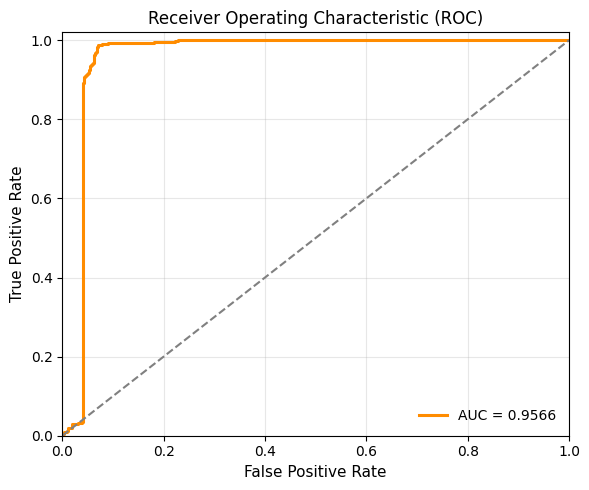

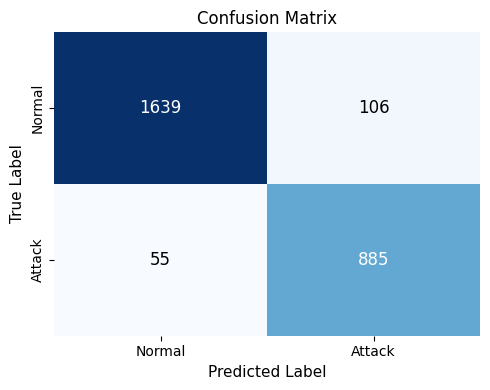

In [5]:
def main():
    device = torch.device(DEVICE)
    mse_calib = None

    # --- mean/std betöltés
    scaler_df = pd.read_csv(NORM_REFERENCE_FILENAME, index_col=0)
    features = scaler_df.index.tolist()
    means = scaler_df["mean"]
    stds  = scaler_df["std"]

    # --- modell betöltés
    model = load_model(MODEL_PATH, len(features), device)
    print(f"Model: {MODEL_PATH.name}")
    print(f"Features: {len(features)} | SeqLen: {SEQUENCE_LENGTH} | Device: {device}")

    if USE_PERCENTILE_THRESHOLD:
        # --- Fájl betöltése ---
        df = pd.read_csv(CALIB_NORMAL_FULL_PATH, encoding="utf-8-sig", header=1)
        df.columns = df.columns.str.strip()

        # --- Csak numerikus + nem konstans feature kiválasztás ---
        numeric_df = df.select_dtypes(include="number")
        min_row = numeric_df.min()
        max_row = numeric_df.max()
        status_row = np.where((max_row - min_row) == 0, "CONST", "VALID")

        transposed_df = pd.DataFrame(
            [min_row.values, max_row.values, status_row],
            columns=min_row.index,
            index=["Min", "Max", "Status"],
        )
        valid_features = transposed_df.columns[transposed_df.loc["Status"] == "VALID"].tolist()
        assert valid_features == features, "Scaler feature list mismatch"

        # --- NaN-ek eltávolítása ---
        df_clean = df[~df[features].isnull().any(axis=1)].copy()

        # --- Időrendi szeletelés ---
        n = len(df_clean)
        train_end = int(n * 0.6)
        calib_end = int(n * 0.8)

        # train_df csak azért kell, hogy az indexek ugyanolyanak legyenek, de nem fogunk új scalert tanítani
        train_df = df_clean.iloc[:train_end].copy()
        calib_df = df_clean.iloc[train_end:calib_end].copy()

        # --- Normalizálás: **MENTETT SCALERREL** ---
        #  itt NEM tanítunk újat, hanem a CSV‑ből betöltött means/stds‑t használjuk
        mu = means.loc[features].to_numpy(dtype=np.float32)
        sd = stds.loc[features].to_numpy(dtype=np.float32)
        sd[sd == 0] = 1.0

        # calib normalizálás
        calib_vals = calib_df[features].to_numpy(dtype=np.float32)
        calib_df[features] = (calib_vals - mu) / sd

        # --- Dataset & Loader ---
        calib_dataset = TempDataset(calib_df, SEQUENCE_LENGTH, features, stride=1)
        calib_loader = DataLoader(
            calib_dataset,
            batch_size=512,
            shuffle=False,
            num_workers=0,
            pin_memory=torch.cuda.is_available(),
            drop_last=False
        )

        # --- MSE számítás ---
        mse_chunks = []
        model.eval()
        with torch.no_grad():
            for batch in calib_loader:
                batch = batch.to(device)
                targets = batch[:, -1, :]
                outputs = model(batch)
                mse_chunks.append(((targets - outputs) ** 2).mean(dim=1).cpu())

        mse_calib = torch.cat(mse_chunks).numpy()
        pred_threshold = float(np.percentile(mse_calib, THRESHOLD_PERCENTILE))

        print(f"\nThreshold from NORMAL CALIB percentile {THRESHOLD_PERCENTILE}: {pred_threshold:.8f}")
        print(f"Normal CALIB MSE: mean={mse_calib.mean():.6f}, std={mse_calib.std():.6f}")


    # ==========================================================
    # 2) EVALUATION (attack-os adaton) — JAVÍTVA (ne írjuk felül a y_pred-et)
    # ==========================================================
    mse_attack, y_true_labels = fast_mse_from_csv(
        ATTACK_PATH, features, means, stds, model, device,
        SEQUENCE_LENGTH, batch_size=256, label_col=LABEL_COL
    )

    allowed_labels = {"Normal", "Attack"}
    found_labels = set(pd.Series(y_true_labels).astype(str).str.strip().unique())
    label_error = found_labels - allowed_labels
    if label_error:
        raise ValueError(f"INVALID LABELS in {LABEL_COL}: {label_error} (allowed: {allowed_labels})")

    y_true = (pd.Series(y_true_labels).astype(str).str.strip().values == "Attack").astype(int)

    # FINAL predikciót külön változóba!
    y_pred_final = (mse_attack > pred_threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_final, labels=[0, 1]).ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)

    # ROC-AUC score-hoz kell, nem a bináris pred
    roc_auc = roc_auc_score(y_true, mse_attack)

    # Attack F1 a FINAL alapján
    f1_attack = classification_report(
        y_true, y_pred_final, target_names=["Normal", "Attack"], output_dict=True
    )["Attack"]["f1-score"]

    print("\n=== FINAL EVALUATION RESULTS ===")
    print(f"{THRESHOLD_PERCENTILE} percentile {pred_threshold:.8f}:")
    print(f"  ➤ TN={tn} | FP={fp} | FN={fn} | TP={tp}")
    print(f"  ➤ Total errors (FP+FN): {fp+fn}")
    print(f"  ➤ Accuracy: {acc:.4f}")
    print(f"  ➤ ROC-AUC: {roc_auc:.4f}")
    print(f"  ➤ Attack F1-score: {f1_attack:.4f}")
    print(f"Attack-set MSE: mean={mse_attack.mean():.6f}, std={mse_attack.std():.6f}")

    print("\nClassification Report (FINAL):")
    print(classification_report(y_true, y_pred_final, target_names=["Normal", "Attack"], digits=4))



    # ==========================================================
    # 3) THRESHOLD SWEEP 
    # ==========================================================
    if USE_PERCENTILE_THRESHOLD:
        print("\n=== Threshold Sweep (for analysis) ===")
        percentiles = [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
                    91, 92, 93, 94, 95, 96, 97, 98, 99, 99.5]
        for p in percentiles:
            thr = np.percentile(mse_calib, p)
            y_pred_sweep = (mse_attack > thr).astype(int)

            tn, fp, fn, tp = confusion_matrix(y_true, y_pred_sweep, labels=[0, 1]).ravel()
            f1 = f1_score(y_true, y_pred_sweep)
            prec = precision_score(y_true, y_pred_sweep, zero_division=0)
            rec = recall_score(y_true, y_pred_sweep, zero_division=0)

            print(f"{p:>5.1f}% | thr={thr:.8f} | F1={f1:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | "
                f"TN={tn} | FP={fp} | FN={fn} | TP={tp}")

    # ==========================================================
    # ROC CURVE
    # ==========================================================
    fpr, tpr, thresholds = roc_curve(y_true, mse_attack)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2.2, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=12)
    plt.legend(loc="lower right", frameon=False)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(
        MODEL_DIR / f"roc_HS{HIDDEN_SIZE}_SL{SEQUENCE_LENGTH}.png",
        dpi=600, bbox_inches="tight"
    )
    # --- save ROC points to CSV (same naming logic) ---
    roc_df = pd.DataFrame({
        "fpr": fpr,
        "tpr": tpr,
        "threshold": thresholds
    })
    roc_df.to_csv(
        MODEL_DIR / f"roc_points_HS{HIDDEN_SIZE}_SL{SEQUENCE_LENGTH}.csv",
        index=False
    )
    plt.show()
    plt.close()
    # ==========================================================
    # CONFUSION MATRIX (seaborn design, FIX: manual annot)
    # ==========================================================
    cm = confusion_matrix(y_true, y_pred_final, labels=[0, 1])
    class_names = ['Normal', 'Attack']
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(
        cm, cmap='Blues',
        xticklabels=class_names, yticklabels=class_names,
        cbar=False
    )

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j + 0.5, i + 0.5, f"{cm[i, j]:d}",
                ha="center", va="center",
                fontsize=12,
                color="white" if cm[i, j] > thresh else "black"
            )


    ax.set_ylim(cm.shape[0], 0)
    plt.xlabel('Predicted Label', fontsize=11)
    plt.ylabel('True Label', fontsize=11)
    plt.title('Confusion Matrix', fontsize=12)
    plt.tight_layout()
    plt.savefig(
        MODEL_DIR / f"cm_HS{HIDDEN_SIZE}_SL{SEQUENCE_LENGTH}.png",
        dpi=600, bbox_inches="tight"
    )
    plt.show()
    plt.close()
    return mse_calib, mse_attack, pred_threshold, y_true, y_pred_final



    

if __name__ == "__main__":
    mse_calib, mse_attack, pred_threshold, y_true, y_pred = main()
      

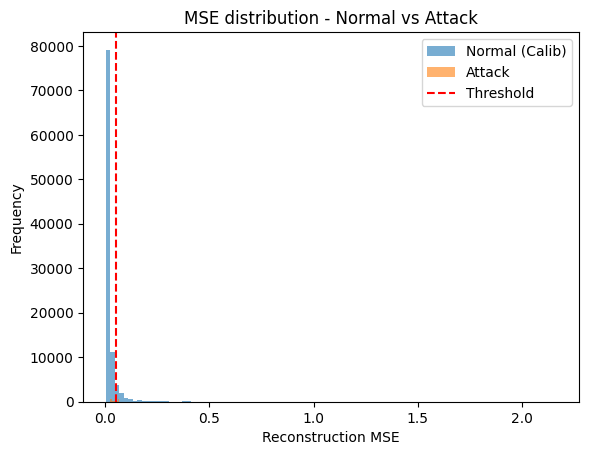

In [6]:
import matplotlib.pyplot as plt
plt.hist(mse_calib, bins=100, alpha=0.6, label="Normal (Calib)")
plt.hist(mse_attack, bins=100, alpha=0.6, label="Attack")
plt.axvline(pred_threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel("Reconstruction MSE")
plt.ylabel("Frequency")
plt.title("MSE distribution - Normal vs Attack")
plt.show()

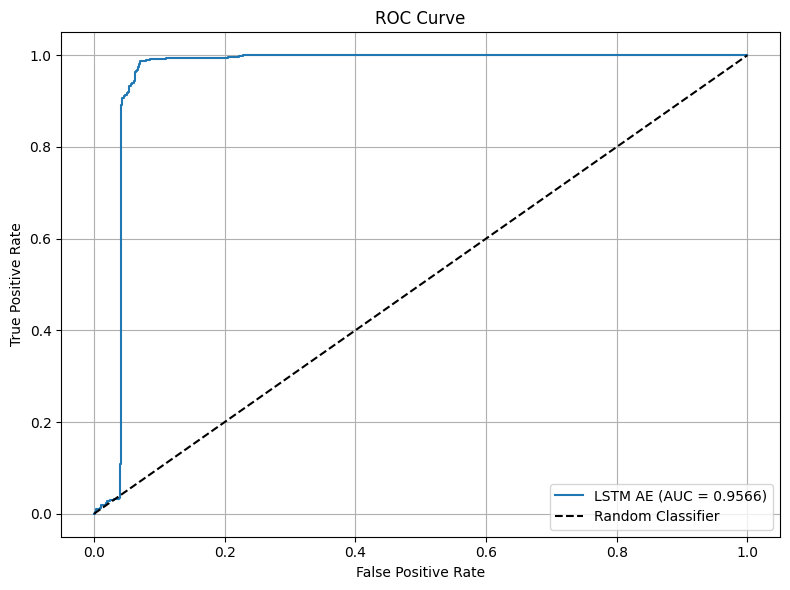

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, scores, model_name="LSTM AE"):
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Meghívás:
plot_roc_curve(y_true, mse_attack)